# Training and deploying a supervised model with SageMaker

- This notebook demonstrates the basic training and deployment of a supervised binary classification model, using the built-in XGBoost algorithm of SageMaker. 
- The dataset used here is originally intended for Fraud Detection: it contains 285K datapoints of anonymized creadit card transaction data. However, you can use any other dataset that suits your use-case. 

## 1. Download, understand and prepare data

Let's start by downloading and reading in the credit card fraud data set.

In [1]:
%%bash
wget https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


--2020-09-22 00:57:02--  https://s3-us-west-2.amazonaws.com/sagemaker-e2e-solutions/fraud-detection/creditcardfraud.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.208.248
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.208.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip’

     0K .......... .......... .......... .......... ..........  0%  306K 3m41s
    50K .......... .......... .......... .......... ..........  0%  305K 3m41s
   100K .......... .......... .......... .......... ..........  0%  307K 3m40s
   150K .......... .......... .......... .......... ..........  0% 50.6M 2m45s
   200K .......... .......... .......... .......... ..........  0%  123M 2m12s
   250K .......... .......... .......... .......... ..........  0%  309K 2m26s
   300K .......... .......... .......... .......... ..........  0% 66.1M 2m6s
   350K ..........

In [5]:
import numpy as np 
import pandas as pd

df_data = pd.read_csv('creditcard.csv', delimiter=',')

Let's take a peek at our data, understand them, check for missing values and class imbalance.

In [6]:
print(df_data.columns)
df_data.head(10)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [21]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The class column corresponds to whether or not a transaction is fradulent. Lets check for the balance between the 2 classes.

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.173


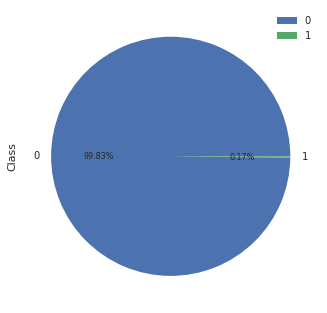

In [27]:
import matplotlib.pyplot as plt

nonfrauds, frauds = df_data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', round(100.*frauds/(frauds + nonfrauds), 3))

plt.style.use('seaborn')
df_data.Class.value_counts().plot.pie(legend=True, autopct='%1.2f%%')
plt.show()

We notice an extreme class imbalance. This is expected for this type of "needle in haystack" problems. 

We will now prepare our features and labels (ground truth) values and split the data to training (90%) and testing (10%).

In [29]:
# prepare features and labels
feature_columns = df_data.columns[:-1]
features = df_data[feature_columns].values.astype('float32')
label_column = df_data.columns[-1]
labels = (df_data[label_column].values).astype('float32')

# split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.1, 
    random_state=0
)

## 2. Upload dataset to S3

SageMaker expects the data to be stored in S3 for training. So we will upload our dataset to S3.

First we copy the data to an **in-memory buffer**. We will use the **svmlight file format**. This format is a text-based format, with one sample per line. It does not store zero valued features hence is suitable for sparse dataset. The first element of each line can be used to store a target variable to predict.

In [31]:
import io
import sklearn
from sklearn.datasets import dump_svmlight_file   

buf = io.BytesIO()

sklearn.datasets.dump_svmlight_file(X_train, y_train, buf)
buf.seek(0);

Now we upload the data to S3 using boto3. Boto3 is a python library that allows us to interface with AWS resources.

In [32]:
import boto3
import os
import sagemaker
from sagemaker import get_execution_role

# set paths
session = sagemaker.Session()
bucket = "fraud-detection-sagemaker-train"
prefix = 'fraud-classifier'
key = 'fraud-dataset'
subdir = 'base'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', subdir, key)).upload_fileobj(buf)  # upload memory buffer to S3

s3_train_data = 's3://{}/{}/train/{}/{}'.format(bucket, prefix, subdir, key)  # train data location 
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))  # trained model will be stored here

Uploaded training data location: s3://fraud-detection-sagemaker-train/fraud-classifier/train/base/fraud-dataset
Training artifacts will be uploaded to: s3://fraud-detection-sagemaker-train/fraud-classifier/output


# 3. Training
We will use Gradient Boosted Trees as our model, as they have a proven track record, are highly scalable and can deal with missing data, reducing the need to pre-process datasets.

We can now train using SageMaker's built-in XGBoost algorithm. To specify the XGBoost algorithm, we use the utility function ```get_image_uri``` to obtain its URI. A complete list of built-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [14]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-2')  # the container of the xgboost algorithm

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


An important parameter here is `scale_pos_weight` which scales the weights of the positive vs. negative class examples. This is crucial to do in an imbalanced dataset like the one we are using here, otherwise the majority class would dominate the learning. Because the data set is so highly skewed, we set the scale position weight conservatively,as **sqrt(num_nonfraud/num_fraud)**. Other recommendations for the ```scale_pos_weight``` are setting it to **num_nonfraud/num_fraud**.

This step may take up to 5 minutes to execute.

In [15]:
from math import sqrt
from sagemaker import get_execution_role

# set the hyperparameters
scale_pos_weight = sqrt(np.count_nonzero(y_train==0)/np.count_nonzero(y_train))  # balancing the weights of the 2 classes

hyperparams = {
    "max_depth":5,
    "subsample":0.8,
    "num_round":100,
    "eta":0.2,
    "gamma":4,
    "min_child_weight":6,
    "silent":0,
    "objective":'binary:logistic',
    "eval_metric":'auc',
    "scale_pos_weight": scale_pos_weight
}

# set the estimator object
clf = sagemaker.estimator.Estimator(
    container,                          
    get_execution_role(),                           
    hyperparameters=hyperparams,                           
    train_instance_count=1,              # how many instances to use                          
    train_instance_type='ml.m4.xlarge',  # what type of instances to use                         
    output_path=output_location,         # where to save the trained model                  
    sagemaker_session=session
)

# start the actual training job
clf.fit({'train': s3_train_data})  

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-22 01:38:51 Starting - Starting the training job...
2020-09-22 01:38:53 Starting - Launching requested ML instances......
2020-09-22 01:40:19 Starting - Preparing the instances for training......
2020-09-22 01:41:21 Downloading - Downloading input data...
2020-09-22 01:41:38 Training - Downloading the training image...
2020-09-22 01:42:08 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[01:42:10] 256326x30 matrix with 7688135 entries loaded from /opt/ml/input/data/train
INFO:root:Single 

## 4. Deploy model to an endpoint

Now we deploy the estimator to an endpoint for real-time inference. 

This step may take **up to 8 minutes** to execute.

In [16]:
from sagemaker.predictor import csv_serializer

predictor = clf.deploy(
    initial_instance_count=1,                   # how many instances to use
    endpoint_name="fraud-detection-endpoint",               
    instance_type='ml.m4.xlarge',               # what type of instance to use
    serializer=csv_serializer,              
    deserializer=None,               
    content_type='text/csv'
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

## 5. Evaluate model

Once we have trained the model we can use it to make predictions for the test set.

In [17]:
# Because we have a large test set, we call predict on smaller batches
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [18]:
y_predict_proba = predict(predictor, X_test)

We will now generate some performance reports to evaluate the deployed model.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


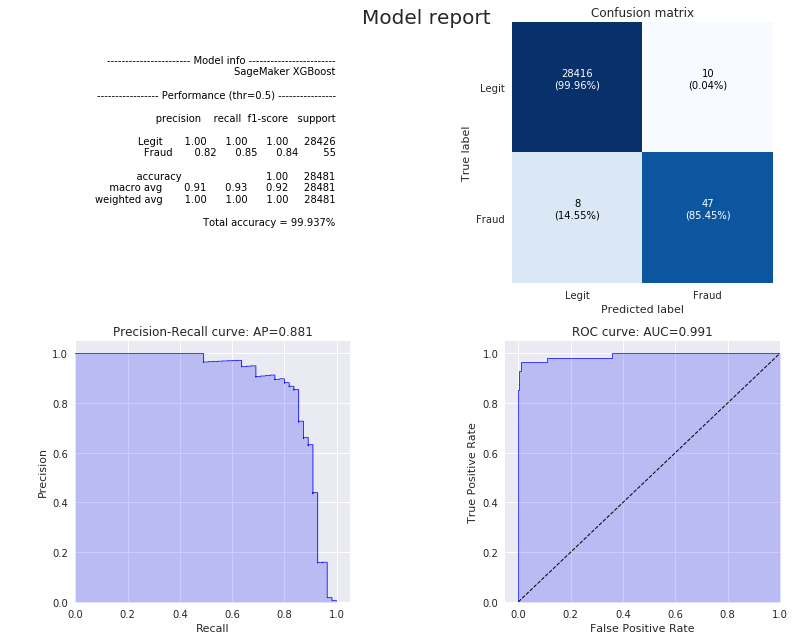

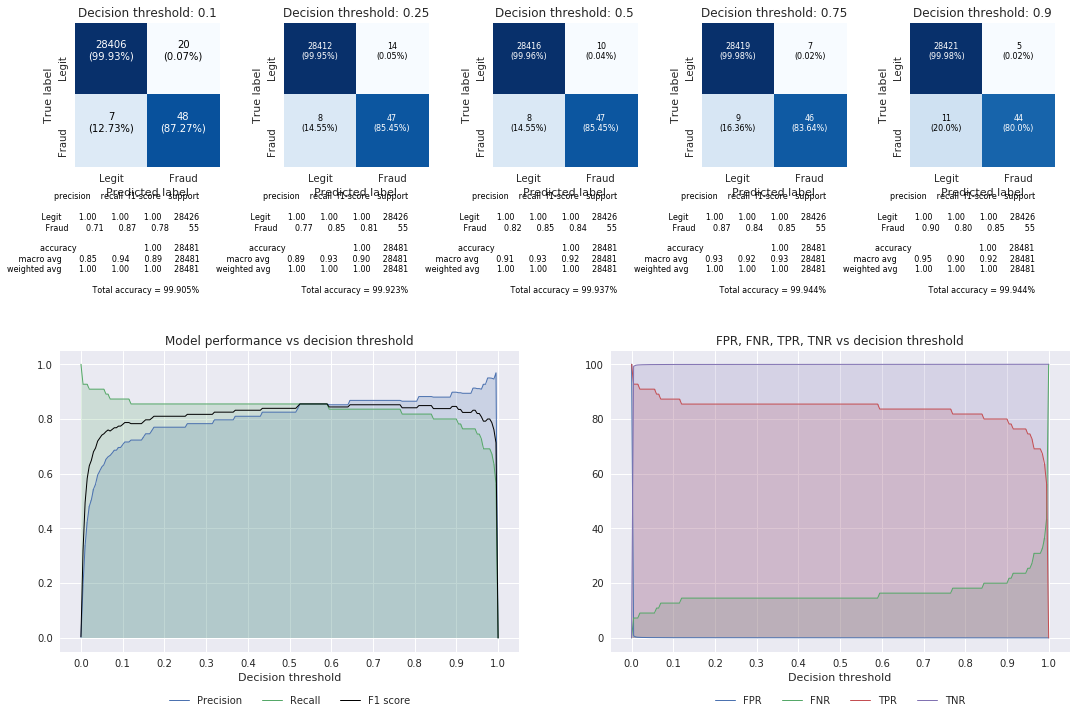

In [33]:
from utils.ml_reporting_tools import generate_classification_report, generate_threshold_report

# generate classification report
generate_classification_report(
        y_actual=y_test,
        y_predict_proba=y_predict_proba, 
        decision_threshold=0.5,
        class_names_list=['Legit','Fraud'],
        model_info='SageMaker XGBoost'
)

# generate classification report
generate_threshold_report(
        y_actual=y_test, 
        y_predict_proba=y_predict_proba, 
        tp_decision_thresholds=(0.1, 0.25, 0.5, 0.75, 0.9), 
        class_names_list=['Legit','Fraud']
)

As we can see, the results are not bad, considering the high imbalance between the two classes. Best F1 performance is achieved for a threshold of ~0.55.

## 6. Accessing the deployed endpoint through API Gateway and Lambda
The CloudFormation template has already generated the following pipeline: API Gateway <-> Lambda <-> SageMaker endpoint.
You can now send https REST requests to API Gateway and get back a response from the SageMaker endpoint. All requests to API Gateway are **signed**. This means that they are encrypted with your own credentials.

In this example, we will use the ```get_api_response``` function from the helper ```inference_endpoint``` package. You can open ```inference_endpoint``` to see in more detail how to sign an API request. It uses your IAM role from this Jupyter notebook to get your credentials and sign the requests.

In [69]:
from utils.inference_endpoint import get_api_response

rest_features = X_test[0,:]  # selecting one of the lines of the test set
response = get_api_response(rest_features)



Status code: 200
Url: https://1bd3rm2so6.execute-api.ap-southeast-1.amazonaws.com/prod/invocations
JSON response: {'fraud_classifier': {'pred_proba': 0.00017772242426872253, 'prediction': 0}}


## 7. Clean up resources

Enpoints incur cost. When you don't need them anymore, you should delete them. You can do that at the Amazon SageMaker console in the Endpoints page, or you can run `predictor_name.delete_endpoint()`

In [ ]:
# Uncomment to clean up endpoints
# predictor.delete_endpoint()


## Data Acknowledgements

The dataset used to demonstrated the fraud detection solution has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project
We cite the following works:
* Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015
* Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon
* Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE
* Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)
* Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier
* Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing